# `microdf` demo

## Setup

In [1]:
import numpy as np
import pandas as pd

import taxcalc as tc
import microdf as mdf

import matplotlib as mpl
import matplotlib.pyplot as plt
import seaborn as sns

Chart options.

In [2]:
mdf.set_plot_style()

/home/mghenis/anaconda3/lib/python3.7/site-packages/microdf/style.py:24: MatplotlibDeprecationWarning: 
The createFontList function was deprecated in Matplotlib 3.2 and will be removed two minor releases later. Use FontManager.addfont instead.
  fm.fontManager.ttflist += fm.createFontList(["Roboto-Regular.ttf"])


## Generate data

In [3]:
base = mdf.calc_df(group_vars=['expanded_income', 'MARS'],
                   metric_vars=['aftertax_income', 'XTOT'])

In [4]:
base.columns

Index(['e02400', 'mcare_ben', 'aftertax_income', 'ssi_ben', 'expanded_income',
       'snap_ben', 'vet_ben', 'housing_ben', 's006', 'other_ben', 'e02300',
       'mcaid_ben', 'XTOT', 'tanf_ben', 'MARS', 'wic_ben', 'market_income',
       'bens', 'tax', 's006_m', 'aftertax_income_m', 'XTOT_m'],
      dtype='object')

Define a reform that treats capital gains as ordinary income and sets the top marginal rate to 70%.

In [5]:
CG_REFORM = {
    'CG_nodiff': {2019: True},
    'II_rt7': {2019: 0.7}
}

In [6]:
reform = mdf.calc_df(reform=CG_REFORM, group_vars=['MARS'], group_n65=True, 
                     metric_vars=['aftertax_income', 'XTOT'])

In [7]:
reform.columns

Index(['vet_ben', 's006', 'e02300', 'MARS', 'e02400', 'mcare_ben', 'ssi_ben',
       'snap_ben', 'housing_ben', 'other_ben', 'aftertax_income',
       'expanded_income', 'mcaid_ben', 'XTOT', 'tanf_ben', 'wic_ben',
       'market_income', 'bens', 'tax', 'n65', 's006_m', 'aftertax_income_m',
       'XTOT_m'],
      dtype='object')

### Calculate senior UBI.

Start with total revenue ($ billions).

In [8]:
new_rev_m = base.aftertax_income_m.sum() - reform.aftertax_income_m.sum()
new_rev_m / 1e3

326.110945495585

How many seniors are there?

In [9]:
mdf.add_weighted_metrics(reform, 'n65')

n65_total_m = reform.n65_m.sum()
n65_total_m

59.21619976999999

Divide.

In [10]:
senior_ubi = new_rev_m / reform.n65_m.sum()
senior_ubi

5507.123840473106

### Add senior UBI to `aftertax_income` and recalculate

In [11]:
reform['ubi'] = senior_ubi * reform.n65
reform['aftertax_income'] = reform.aftertax_income + reform.ubi
mdf.add_weighted_metrics(reform, 'aftertax_income')

In [12]:
np.allclose(base.aftertax_income_m.sum(), reform.aftertax_income_m.sum())

True

## Analyze

Gini, FPL, distributional impact chart

### Change to Gini index

In [13]:
mdf.gini(base, 'aftertax_income', 's006')

0.5032911973267852

In [14]:
mdf.gini(reform, 'aftertax_income', 's006')

0.48752755152259336

### Change to poverty rate

Add federal poverty line with `mdf.fpl`.

In [15]:
base['fpl'] = mdf.fpl(base.XTOT)
reform['fpl'] = mdf.fpl(reform.XTOT)

base['fpl_XTOT_m'] = np.where(base.aftertax_income < base.fpl,
                              base.XTOT_m, 0)
reform['fpl_XTOT_m'] = np.where(reform.aftertax_income < reform.fpl,
                                reform.XTOT_m, 0)

In [16]:
reform.fpl_XTOT_m.sum() / base.fpl_XTOT_m.sum() - 1

-0.022307196800575246

Add chart.

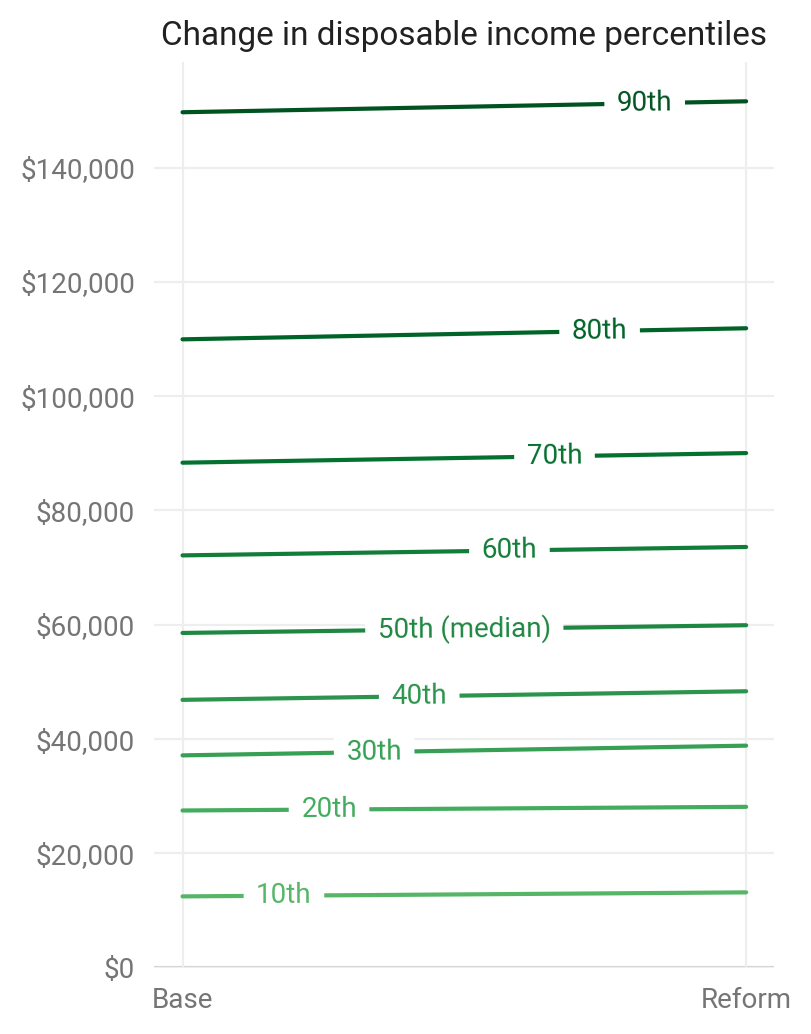

In [17]:
ax = mdf.quantile_chg_plot(base, reform, 'aftertax_income', 'aftertax_income',
                           'XTOT_m', 'XTOT_m')